In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage.filters import uniform_filter1d
from scipy.stats import t as TD
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from statsmodels.graphics.gofplots import ProbPlot

In [2]:
log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

In [3]:
# moving averages of different time span
def mov_avg(A, B, window_length=60):
    # Input: two 1440 x 1 numpy arrays
    # Output: two 288 x 1 numpy arrays
    
    pr_avg = uniform_filter1d(A, size=window_length, mode='nearest')[::30]
    vo_avg = uniform_filter1d(B, size=window_length, mode='nearest')[::30]

    return pr_avg[-10:], vo_avg[-5:]

In [4]:
def MACD(A):
    # Input: 1440 x 1 DataFrame
    # Output: two 1440 x 1 numpy array
    df = np.exp(A)
        
    # Get the 26-day EMA of the closing price
    k = df.ewm(span=26, adjust=False, min_periods=26).mean()
    # Get the 12-day EMA of the closing price
    d = df.ewm(span=12, adjust=False, min_periods=12).mean()

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = np.array(macd.ewm(span=9, adjust=False, min_periods=9).mean())

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    #macd_h = macd - macd_s
    
    return np.array(macd), macd_s #, macd_h

In [5]:
def np_ewma_vectorized(data, window, method = "WMS"):

    if method == "WMS":
        alpha = 1 / window
    elif method == "EMA":
        alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1 / pows[:-1]
    offset = data[0] * pows[1:]
    pw0 = alpha * alpha_rev**(n-1)

    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out


def MACD(A):
    # Input: 1440 x 1 DataFrame
    # Output: two 1440 x 1 numpy array
    A = np.exp(A)
        
    # Get the 26-day EMA of the closing price
    k = np_ewma_vectorized(A, 26)
    # Get the 12-day EMA of the closing price
    d = np_ewma_vectorized(A, 12)

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    #Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = np.array(np_ewma_vectorized(macd, 9))

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    #macd_h = macd - macd_s
    
    if abs(k[-1] - k[-2] - d[-1] + d[-2]) > 0.001:
        return ((k[-1] - k[-2] - d[-1] + d[-2]), k, d, np.array(macd))
    else:
        return (0, k, d, np.array(macd))
    
    if (k[-1] - k[-2] - d[-1] + d[-2]) > 0.001:
        return (np.array([0.1]), k, d, np.array(macd))#, macd_s#, macd_h
    elif (k[-1] - k[-2] - d[-1] + d[-2]) < -0.001:
        return (np.array([-0.1]), k, d, np.array(macd))#, macd_s#, macd_h
    else:
        return (np.array([0]), k, d, np.array(macd))#, macd_s#, macd_h

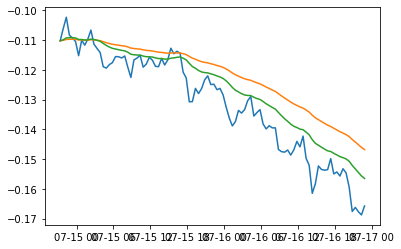

In [6]:
A = log_pr.iloc[20000:23000:30,0]
_, k, d, macd1 = MACD(A)
plt.plot(A)
plt.plot(np.log(k))
plt.plot(np.log(d))

In [7]:
A = log_pr.iloc[20000:23000,0]
k, d, macd1 = MACD(A)
plt.plot(A + 1)
plt.plot(k)
plt.plot(d)

ValueError: too many values to unpack (expected 3)

In [8]:
def RSI_np(A, window_length=14):
    """
    Calculate RSI
    A: numpy array of log price
    method : "SMA": simple moving average,
            "WMS": Wilder Smoothing Method,
            "EMA": exponential moving average
    
    Return RSI for last three periods
    """
    # transform log-price to price
    A = np.exp(A)
    tmp = np.diff(A)

    gain = np.clip(tmp, a_min = 0, a_max = None)
    loss = np.abs(np.clip(tmp, a_min = None, a_max = 0))

    avg_gain = np_ewma_vectorized(gain, window_length, 'WMS')#[-10:]
    avg_loss = np_ewma_vectorized(loss, window_length, 'WMS')#[-10:]
    
    rsi1 = 100 - (100 * avg_loss / (avg_loss + avg_gain))
        
    avg_gain = np_ewma_vectorized(gain, window_length, 'EMA')#[-10:]
    avg_loss = np_ewma_vectorized(loss, window_length, 'EMA')#[-10:]
    
    #rs = avg_gain / avg_loss
    rsi2 = 100 - (100 * avg_loss / (avg_loss + avg_gain))
    return rsi1[-2:], rsi2[-2:]

NameError: name 'rsi' is not defined

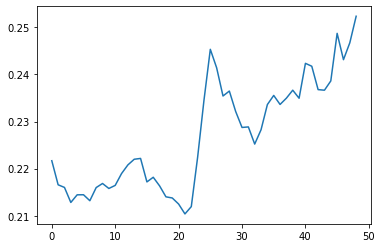

In [9]:
A = log_pr.iloc[1440*139:(1440*140+30):30,3]
#rsi = RSI_np(A)
plt.plot(A.values)
plt.plot(rsi / 1000 + 0.3)

In [10]:
plt.plot(rsi)

NameError: name 'rsi' is not defined

In [11]:
np.corrcoef((A[1:].values - A[:-1].values), rsi)


NameError: name 'rsi' is not defined

In [12]:
def volChanges(B, window_length=30):
    vol0 = np.mean(B[-30:])
    vol1 = np.mean(B[-60:-30])
    vol2 = np.mean(B[-90:-60])
    vol3 = np.mean(B[-120:-90])
    # vol4 = np.mean(B[-180:-120])
    
    return np.array([vol2-vol3, vol1-vol2, vol0-vol1, vol0])

In [13]:
def getVolRatios(vol, volWindow=[10, 30, 60]):  
    # Input: 1440 x 1 numpy array
    # the window here is in minutes
    # Output: 3 dim numpy array
    
    return np.array([sum(vol[-win:]) for win in volWindow]) / sum(vol)

In [14]:
def priceVolCor(A, B, time=[1440, 720, 360]):
    # Input: two 1440 x 1 numpy arrays
    # Output: 3 dim numpy array
    
    pv_cor = A
    temp = np.hstack((A, B))
    pv_cor = [np.corrcoef(temp[-t:]) for t in time]
    return np.array(pv_cor)

In [15]:
# z-score of log-price
def zScorePr(A):
    # Input: 1440 x 1 numpy array
    # Output: 3 dim numpy array
    # the moving average log-price of 30min, 1h, and 3h

    A = np.hstack((A[0]*np.ones(90), A, A[-1]*np.ones(90)))
    
    # moving averages of 30 minutes
    N = 15
    pr_avg_0 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    # 1 hour (60 minutes)
    N = 30
    pr_avg_1 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    # 2 hour (120 minutes)
    N = 60
    pr_avg_2 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    # 3 hours (180 minutes)
    N = 90
    pr_avg_3 = np.convolve(A[(90-N):-(91-N)], np.ones(2*N)/N/2, mode='valid')
    
    z0 = (A[-1] - pr_avg_0[-1]) / np.std(pr_avg_0)
    z1 = (A[-1] - pr_avg_1[-1]) / np.std(pr_avg_1)
    z2 = (A[-1] - pr_avg_2[-1]) / np.std(pr_avg_2)
    z3 = (A[-1] - pr_avg_3[-1]) / np.std(pr_avg_3)
    return np.array([z0, z1, z2, z3])

In [101]:
def neglogr(A, asset):
    params = [158, 279, 100, 15, 32, 7, 37, 6, 36, 82]
    #params = [30] * 10
    return A[-1*params[asset]] - A[-1]

In [17]:
with open('tDistr.pkl', 'rb') as f:
    paramsDict = pickle.load(f)

def getTdist(A, assetVal):
    return TD.cdf(
      A[-1] - A[-31], 
      df = paramsDict[assetVal]["df"], 
      loc = paramsDict[assetVal]["loc"], 
      scale = paramsDict[assetVal]["scale"]
    )

In [18]:
volmean = {}
volstd = {}

for j in range(10):
    logVol = np.log10(volu.iloc[:, j])
    if j == 2:
        logVol = np.log10(volu.iloc[1440*136:, j])
    volmean[j] = np.mean(logVol)
    volstd[j] = np.std(logVol)

/Users/xinhew/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [103]:
def get_features(A, B, asset):
    global volmean, volstd
    m1, m2 = mov_avg(np.exp(A), B)
    indi, macd1, _, macd = MACD(A[::30])
    rsi1, rsi2 = RSI_np(np.exp(A[::30]))
    return np.hstack((
        0, #(m1[-1] - np.exp(A[-1])) / m1[-1], #m2,
        indi, (np.log(macd1[-1]) - A[-1]) / np.log(macd1[-1]), #macd[-1],
        rsi1, rsi2,
        volChanges(B)[2:],
        #getVolRatios(B),
        #priceVolCor(A, B),
        zScorePr(np.exp(A))[:2],
        neglogr(A, asset),
        getTdist(A, asset),
        np.mean(A), np.std(A), (A[-1] - np.mean(A)) / np.std(A),
        1 #(np.mean(np.log10(B[-3:])) - volmean[asset]) / volstd[asset]
    )).reshape((1, -1))

In [20]:
f = get_features(log_pr.iloc[:1440,0], volu.iloc[:1440,0], 0)
p = np.shape(f)[1]
print(len(log_pr.iloc[0:1440,0]), f.shape)
print(f)

1440 (1, 17)
[[ 0.00000000e+00  0.00000000e+00 -5.88234047e+00  3.32136652e+01
   3.20391628e+01  2.61249465e+01  2.42080364e+01 -4.57536105e+04
   1.97991318e+05 -6.96990193e-02 -7.48758804e-02  1.56663059e-03
   3.56492946e-01 -1.83705017e-03  5.37114066e-03 -2.11288978e+00
  -3.73895646e-01]]


In [104]:
# compute and save the feature "pool"

feature = {}
ytrain = {}
feature_test = {}

test_res = []
selected_rank2 = []

ytest = []
pred = []

for asset in range(10):
    t0 = time.time()
    
    fs = get_features(log_pr.iloc[1440*63:1440*64, asset], volu.iloc[1440*63:1440*64, asset], asset)
    y = log_pr.iloc[1440*64+29, asset] - log_pr.iloc[1440*64-1, asset]
    #y = np.mean(log_pr.iloc[(1440+27):(1440+32), asset]) - log_pr.iloc[1440-1, asset]
    
    d = 10

    for t in range(1440*63, 1440*183 - 30)[d::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset], asset)
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]
        ))

    #t_used = time.time() - t0
    #print(t_used, np.shape(fs), np.shape(y))
    
    feature[asset] = fs
    ytrain[asset] = y
    
    ftest = get_features(log_pr.iloc[:1440*1, asset], volu.iloc[:1440*1, asset], asset)
    ytest.append(log_pr.iloc[1440*1+29, asset] - log_pr.iloc[1440*1-1, asset])
    
    d = 10

    for t in range(0,1440*62-1470,d): # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset], asset)
        ftest = np.vstack((ftest, f))
        ytest.append(log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset])
    
    feature_test[asset] = ftest
    
    t_used = time.time() - t0
    print(t_used, np.shape(ftest), np.shape(ytest))


50.29247784614563 (8782, 17) (8782,)
50.491703033447266 (8782, 17) (17564,)
50.21328806877136 (8782, 17) (26346,)
50.41482925415039 (8782, 17) (35128,)
50.37596797943115 (8782, 17) (43910,)
50.071455001831055 (8782, 17) (52692,)
50.195226192474365 (8782, 17) (61474,)
50.27958822250366 (8782, 17) (70256,)
50.155869007110596 (8782, 17) (79038,)
50.46501803398132 (8782, 17) (87820,)


In [105]:
# save files
a_file = open("feature_train.pkl", "wb")
pickle.dump(feature, a_file)
a_file.close()

a_file = open("feature_test.pkl", "wb")
pickle.dump(feature_test, a_file)
a_file.close()

a_file = open("y_train.pkl", "wb")
pickle.dump(ytrain, a_file)
a_file.close()

a_file = open("y_test.pkl", "wb")
pickle.dump(ytest, a_file)
a_file.close()

#a_file = open("data.pkl", "rb")
#output = pickle.load(a_file)

In [106]:
# read files
a_file = open("feature_train.pkl", "rb")
feature = pickle.load(a_file)
a_file.close()

a_file = open("feature_test.pkl", "rb")
feature_test = pickle.load(a_file)
a_file.close()

a_file = open("y_train.pkl", "rb")
ytrain = pickle.load(a_file)
a_file.close()

a_file = open("y_test.pkl", "rb")
ytest = pickle.load(a_file)
a_file.close()

In [107]:
# truncate outliers in y
def removeOutliers(A):
    mean = np.mean(A)
    std = np.std(A)
    A[A > mean + 4*std] = mean + 6*std
    A[A < mean - 4*std] = mean - 6*std
    return A

for j in range(10):
    ytrain[j] = removeOutliers(ytrain[j])

In [108]:
# truncate outliers in X
for j in range(10):
    for i in range(p):
        if p == 12:
            continue
        feature[j][:,i] = removeOutliers(feature[j][:,i])
p

17

/Users/xinhew/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

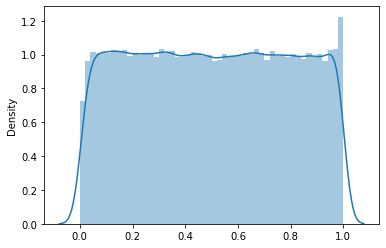

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use(seaborn-darkgrid)

log_return = log_pr.iloc[30:,:].values - log_pr.iloc[:-30,:].values

sns.distplot([feature[i][:,12] for i in range(10)])

In [25]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = - smf.ols(formula, data).fit().aic#rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [109]:
# fit a uniform model to 10 assets and select features

# first combine the X's
Xcom = np.vstack((feature[0], feature[1]))
for j in range(2,10):
    Xcom = np.vstack((Xcom, feature[j]))
    
print(Xcom.shape)

# then combine y's
ycom = np.vstack((ytrain[0], ytrain[1]))
for j in range(2,10):
    ycom = np.vstack((ycom, ytrain[j]))
    
print(ycom.shape)

# fit a least squares model
Xcom[:, [7,8]] = Xcom[:, [7,8]] / 10**8

p = 17
df = pd.DataFrame(Xcom[:,[1,4,6,8,10,11,12,13]], columns=['x' + str(i) for i in range(8)])
df['y'] = ycom
model = forward_selected(df, 'y')
print(model.summary())


(172770, 17)
(172770, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     74.05
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          1.64e-122
Time:                        22:32:17   Log-Likelihood:             6.7545e+05
No. Observations:              172770   AIC:                        -1.351e+06
Df Residuals:                  172761   BIC:                        -1.351e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001   6.3

/Users/xinhew/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xinhew/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/xinhew/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xinhew/opt/ana

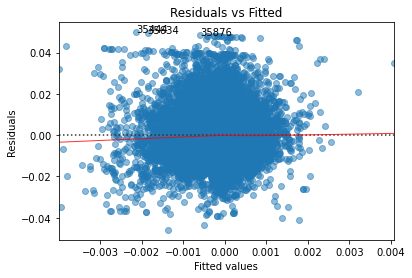

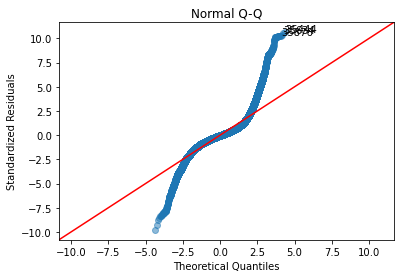

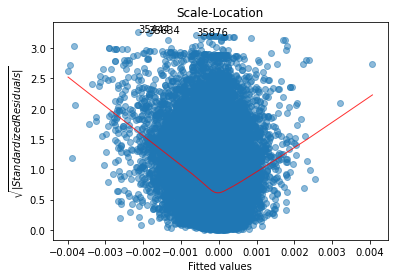

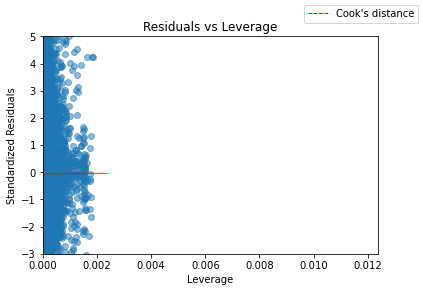

In [88]:
diagnostic_plots(X=df.iloc[:,0:6], y=df['y'])


In [78]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model

    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)

    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]

    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

In [128]:
# test on the first two months

test_res = []
selected_rank2 = []

ytest = []
pred = []

# selected features

flist = [9,11,13]

for asset in range(10):
    t0 = time.time()
    '''
    fs = get_features(log_pr.iloc[:1440, asset], volu.iloc[:1440, asset])
    y = log_pr.iloc[1440+29, asset] - log_pr.iloc[1440-1, asset]
    #y = np.mean(log_pr.iloc[(1440+27):(1440+32), asset]) - log_pr.iloc[1440-1, asset]
    
    d = 10

    for t in range(1440*121 - 30)[d::d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]
        ))
    '''
    
    fs = np.array(feature[asset])
    y = np.array(ytrain[asset])
    fs[:, [7,8]] = fs[:, [7,8]] / 10**8
    fs = fs[:, flist]
    
    df = pd.DataFrame(fs, columns=['x' + str(i) for i in range(len(flist))])
    df['y'] = y
    
    #model = forward_selected(df, 'y')
    #print(model.summary())
    
    #lm = sm.OLS.from_formula('y ~ x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15', data=df)
    #res = lm.fit()
    #print(res.aic)
    
    model = LinearRegression()
    model.fit(Xcom[:,flist], ycom)
    
    
    #ftest = get_features(log_pr.iloc[1440*122:1440*123, asset], volu.iloc[1440*122:1440*123, asset])
    ytest.append(log_pr.iloc[1440*1+29, asset] - log_pr.iloc[1440*1-1, asset])
    
    d = 10

    for t in range(0,1440*62-1470,d): # compute the predictions every 10 minutes
        #f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        #ftest = np.vstack((ftest, f))
        ytest.append(log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset])
    
    
    ftest = np.array(feature_test[asset])
    ytes = np.array(ytest)[asset*8781:(asset+1)*8781]
    
    ftest[:, [7,8]] = ftest[:, [7,8]] / 10**8
    ftest = ftest[:, flist]
    pred.append(model.predict(ftest))
    
    t_used = time.time() - t0
    print(t_used, np.shape(ftest), np.shape(ytest), np.shape(pred))
    
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])



0.23592686653137207 (8782, 3) (8782,) (1, 8782, 1)
0.21765995025634766 (8782, 3) (17564,) (2, 8782, 1)
0.21830296516418457 (8782, 3) (26346,) (3, 8782, 1)
0.2193288803100586 (8782, 3) (35128,) (4, 8782, 1)
0.21952009201049805 (8782, 3) (43910,) (5, 8782, 1)
0.21954774856567383 (8782, 3) (52692,) (6, 8782, 1)
0.22257089614868164 (8782, 3) (61474,) (7, 8782, 1)
0.22082114219665527 (8782, 3) (70256,) (8, 8782, 1)
0.22133421897888184 (8782, 3) (79038,) (9, 8782, 1)
0.2192528247833252 (8782, 3) (87820,) (10, 8782, 1)


In [129]:
[np.corrcoef(
    np.array(pred).reshape((1,-1))[0, k*8781:(k+1)*8781],
    np.array(ytest)[k*8781:(k+1)*8781]
)[0, 1] for k in range(10)]

[0.0770792559274461,
 0.07418819549726179,
 0.03828193567514306,
 0.06034998468141834,
 0.10309810865699137,
 0.0145246309869994,
 0.0327096036968216,
 0.09901746342694641,
 0.07107857748775046,
 0.0013570549998650006]

In [130]:
print(np.shape(fs), np.shape(y))
np.corrcoef(np.array(pred).reshape((1,-1)), np.array(ytest))

(17277, 3) (17277, 1)


array([[1.        , 0.05419808],
       [0.05419808, 1.        ]])

In [131]:
with open('./model.pkl', 'wb') as f:
        pickle.dump(model,f)

In [717]:
# train the models for submission using last 4 months of data

for asset in range(10):
    t0 = time.time()
    
    d0 = 180
    if asset == 2:
        d0 = 135

    fs = get_features(
        log_pr.iloc[(-1440*d0-10):(-1440*(d0-1)-10), asset], 
        volu.iloc[(-1440*d0-10):(-1440*(d0-1)-10), asset], asset
    )
    y = log_pr.iloc[-1440*d0+29, asset] - log_pr.iloc[-1440*(d0-1)-1, asset]

    '''
    d = 10

    for t in range(1440 * 0, 1440 * 60, d): 
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset])
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            np.mean(log_pr.iloc[(t+1440+27):(t+1440+33), asset])
        ))
    '''
    d = 10

    for t in range(264960)[(-1440*d0):-1469:d]: # compute the predictions every 10 minutes
        f = get_features(log_pr.iloc[t:(t+1440), asset], volu.iloc[t:(t+1440), asset], asset)
        fs = np.vstack((fs, f))
        y = np.vstack((
            y, 
            log_pr.iloc[t+1440+29, asset] - log_pr.iloc[t+1440-1, asset]
        ))
        
    fs[:, [7,8]] = fs[:, [7,8]] / 10**8
    fs = fs[:, flist[asset]]
    
    df = pd.DataFrame(fs, columns=['x' + str(i) for i in range(len(flist[asset]))])
    df['y'] = y
    
    #model = forward_selected(df, 'y')
    #print(model.summary())
    
    t_used = time.time() - t0
    print(t_used, np.shape(fs), np.shape(y))
    
    model = LinearRegression()
    model.fit(fs, y)

    #pred = model.predict(ftest)
    #test_res.append(np.corrcoef(pred[:,0], ytest[:,0])[0,1])
    with open('./model_{}.pkl'.format(asset),'wb') as f:
        pickle.dump(model,f)
    
    #select = RFE(model, n_features_to_select=100, step=2).fit(fs, y)
    #selected.append([i for i in range(p) if select.support_[i]])
    #selected_rank.append(select.ranking_)

45.45023274421692 (25775, 5) (25775, 1)
47.85417294502258 (25775, 6) (25775, 1)
34.297744035720825 (19295, 7) (19295, 1)
46.27171087265015 (25775, 5) (25775, 1)
46.304991006851196 (25775, 7) (25775, 1)
46.32366108894348 (25775, 5) (25775, 1)
45.88448619842529 (25775, 5) (25775, 1)
45.849770069122314 (25775, 5) (25775, 1)
45.9497447013855 (25775, 5) (25775, 1)
46.01285099983215 (25775, 7) (25775, 1)


In [208]:
variables = [f'm1_{i}' for i in range(1)]\
+ ['MACDslope']\
+ ['MACD[-1]']\
+ [f'RSI1_{i}' for i in range(2)]\
+ [f'RSI2_{i}' for i in range(2)]\
+ [f'VolChange_{i}' for i in range(2)]\
+ [f'zScore_{i}' for i in range(2)]\
+ ["neg30logr"] + ["tDist"]

In [209]:
flist = [[1,6,8,9,11],
         [1,6,7,9,10,11],
         [1,6,7,8,9,10,11],
         [7,8,9,10,11],
         [1,6,7,8,9,10,11],
         [7,8,9,10,11],
         [7,8,9,10,11],
         [1,6,7,8,9],
         [1,8,9,10,11],
         [1,6,7,8,9,10,11]
        ]

for asset in range(10):
    print(asset, [variables[fea] for fea in flist[asset]])

0 ['MACDslope', 'RSI2_1', 'VolChange_1', 'zScore_0', 'neg30logr']
1 ['MACDslope', 'RSI2_1', 'VolChange_0', 'zScore_0', 'zScore_1', 'neg30logr']
2 ['MACDslope', 'RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
3 ['VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
4 ['MACDslope', 'RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
5 ['VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
6 ['VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
7 ['MACDslope', 'RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0']
8 ['MACDslope', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
9 ['MACDslope', 'RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']


In [385]:
flist = [[6,7,8,9,10,11],
         [6,7,8,10,11],
         [7,8,9,10],#8
         [7,8,9,10],#9
         [6,7,8,9,10,11],#7
         [7,8,9,10,11],
         [6,7,8,9,10,11],
         [6,7,8,9,11],
         [6,7,8,9,10,11],#7
         [6,7,8,9,10,11]
        ]
for asset in range(10):
    print([variables[fea] for fea in flist[asset]])

['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_1', 'neg30logr']
['VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1']
['VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1']
['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
['VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'neg30logr']
['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
['RSI2_1', 'VolChange_0', 'VolChange_1', 'zScore_0', 'zScore_1', 'neg30logr']
